# Prediction of Stocks Closing Prices using Time Series Analysis

Stock Morkets are an extremely volatile entity. It is difficult to predict their nature with a single glance, as they are affected by a lot of different factors. However, we can assume that they have an inherent pattern, and arent affected randomly, which allows us to predict their behaviour. 

In this notebook, we will explore a method of closing price prediction of some stock market Datasets

First, we will import the necessary libraries. The model has been constructed using Python's Keras library, with Tensorflow backend.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers

import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline

path_to_csv = 'C:/Users/bachu/Documents/Python Scripts/DSP Miniproject/Datasets/GS.csv'

# Loading and Analysing the data

In this notebook, we will be using historical data from the TCS stock, from 2010 till 2020. We will use data until 2017 for training, and data from 2017 for validation

In [2]:
data = pd.read_csv(path_to_csv)
closing_prices = list(data['Close'].interpolate())
dates = list(data['Date'])

In [3]:
split_size = 0.7
window_size = 30
learning_rate = 0.01
batch_size = 32
buffer = 100
epochs = 200
split_point = int(split_size*len(data))

sc = MinMaxScaler(feature_range = (0, 1))

In [4]:
train_prices = closing_prices[:split_point]
val_prices = closing_prices[split_point:]

train_dates = dates[:split_point]
val_dates = dates[split_point:]

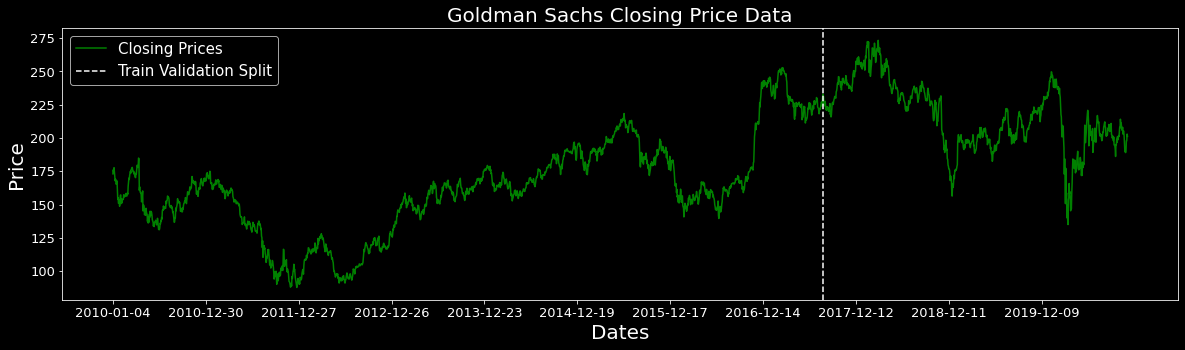

In [5]:
plt.style.use('dark_background')
plt.figure(figsize = (20, 5))
date_ticks = []
x_ticks_pos = []
for i, j in enumerate(dates):
  if not i%250:
    date_ticks.append(j)
    x_ticks_pos.append(i)

plt.plot(closing_prices, color = 'g')
plt.axvline(split_point, color = 'w', linestyle = '--')
plt.xticks(x_ticks_pos, date_ticks)
plt.tick_params(axis='both', labelsize = 13)
plt.title('Goldman Sachs Closing Price Data', fontsize = 20)
plt.legend(['Closing Prices', 'Train Validation Split'], fontsize = 15)
plt.xlabel('Dates', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.show()

# fig, ax = plt.subplots(2, 1, figsize = (20, 5), constrained_layout = True)

# ax[0].plot(train_prices, color = 'r')
# ax[0].set_title('Train Data', fontsize = 15)

# plt.sca(ax[0])
# plt.xticks(x_ticks_pos[:train_val_split_point//200], 
# date_ticks[:train_val_split_point//200])

# ax[1].plot(val_prices, color = 'y')
# ax[1].set_xticks(x_ticks_pos[train_val_split_point//200:], date_ticks[train_val_split_point//200:])
# ax[1].set_title('Validation Data', fontsize = 15)

# plt.sca(ax[1])
# plt.xticks(np.arange(len(val_prices)//200).tolist(), date_ticks[train_val_split_point//200:])


# Error Calculation

We will calculate the error using the MSE metric (Mean Squared Error), which is commonly used for determining the quality of the prediction.

### <center>$Error = \frac{1}{n}\sum_{i=1}^{n} {(A_i - P_i)^2}$</center>

Where n is the length of the data being considered, and i iterates from 1st datapoint to the end.
$A_i$ and $P_i$ refer to the actual and predicted value at i respectively

# Prediction with a Moving Average Window

Moving average calculates a rolling average of all values inside a fixed window length. This gives a rough prediction for the stock prices. We will be using this as a baseline for the model accuracy.

Moving Average Formula:

### <center>$y[i] = \frac{1}{M}\sum_{j = 1}^M x[i-j]$</center>


Where M is the window length, i is the current sample, and j iterates from 1 to the Window size. Needless to say, the moving average is calculated only after M samples and not from the start of the signal

In [6]:
def get_windows(data, window):
  windows = []
  for i in range(len(data) - window):
    windows.append(data[i:i+window])
  return np.array(windows)

In [7]:
def get_ma_predictions(data, window):
  windowed = get_windows(data, window)
  mov_avj_preds = [0]*(window+1) + [sum(i)/window for i in windowed][:-1]
  return np.array(mov_avj_preds)  

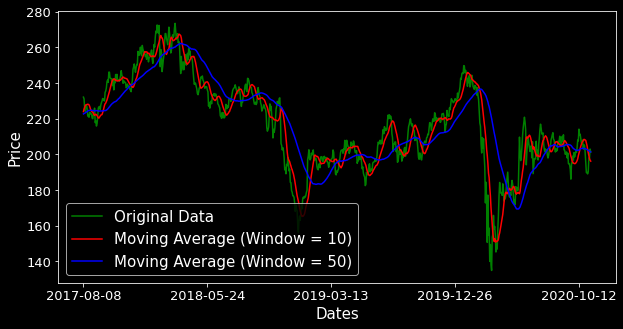

In [8]:
data_ma_5 = get_ma_predictions(closing_prices, window = 5)
data_ma_10 = get_ma_predictions(closing_prices, window = 10)
data_ma_20 = get_ma_predictions(closing_prices, window = 20)
data_ma_50 = get_ma_predictions(closing_prices, window = 50)

date_ticks = []
x_ticks_pos = []
for i, j in enumerate(val_dates):
  if not i%200:
    date_ticks.append(j)
    x_ticks_pos.append(i)

plt.figure(figsize = (10, 5))
plt.plot(val_prices, 'g')
# plt.plot(data_ma_5)
plt.plot(data_ma_10[split_point:], 'r')
# plt.plot(data_ma_20)
plt.plot(data_ma_50[split_point:], 'b')
plt.xticks(x_ticks_pos, date_ticks)
plt.tick_params(axis='both', labelsize = 13)
plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Price', fontsize = 15)
plt.legend(['Original Data', 'Moving Average (Window = 10)', 'Moving Average (Window = 50)'], fontsize = 15)
plt.show()

In [9]:
print("Error by MA 10: ", mse(closing_prices[split_point:], data_ma_10[split_point:]))
print("Error by MA 50: ", mse(closing_prices[split_point:], data_ma_50[split_point:]))

Error by MA 10:  76.7749488029674
Error by MA 50:  268.1591537931978


Clearly, the moving average with lower window size predicts better. But in real life, the stock depends on the values from many time steps back, usually more than 30. But this will not give a good prediction with a Moving Average because we assume that all price points have an equal weight distribution of $\frac {1}{n}$. Instead, we can modify the weight distribution to give more dependence on the newer values. This is called the weighted moving average.

### <center>$y[i] = \sum_{j = 1}^M x[i-j]m[j]$</center>
Where 
### <center> $\sum_{j = 1}^M m[j] = 1$</center>
And $m[j]$ increases for $j$ closer to $M$.

In [10]:
def get_wma_predictions(data, window):
  weights = np.arange(1, window + 1)
  weights = weights/np.sum(weights)
  windowed = get_windows(data, window)
  preds = [0]*(window+1)
  for i in windowed:
    pred = np.sum(i*weights)
    preds.append(pred)
  return np.array(preds[:-1])

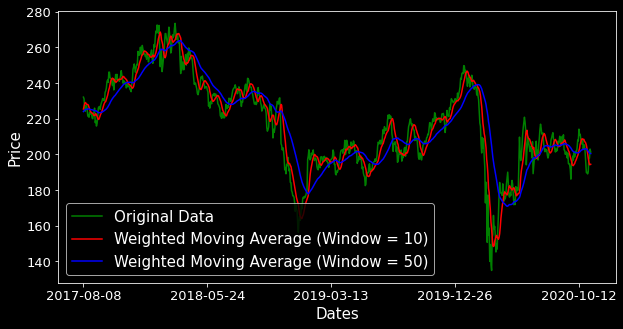

In [11]:
data_wma_5 = get_wma_predictions(closing_prices, window = 5)
data_wma_10 = get_wma_predictions(closing_prices, window = 10)
data_wma_20 = get_wma_predictions(closing_prices, window = 20)
data_wma_50 = get_wma_predictions(closing_prices, window = 50)

date_ticks = []
x_ticks_pos = []
for i, j in enumerate(val_dates):
  if not i%200:
    date_ticks.append(j)
    x_ticks_pos.append(i)

plt.figure(figsize = (10, 5))
plt.plot(val_prices, 'g')
# plt.plot(data_wma_5)
plt.plot(data_wma_10[split_point:], 'r')
# plt.plot(data_wma_20)
plt.plot(data_wma_50[split_point:], 'b')
plt.xticks(x_ticks_pos, date_ticks)
plt.tick_params(axis='both', labelsize = 13)
plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Price', fontsize = 15)
plt.legend(['Original Data', 'Weighted Moving Average (Window = 10)', 'Weighted Moving Average (Window = 50)'], fontsize = 15)
plt.show()

In [12]:
print("Error by WMA 10: ", mse(closing_prices[split_point:], data_wma_10[split_point:]))
print("Error by WMA 50: ", mse(closing_prices[split_point:], data_wma_50[split_point:]))

Error by WMA 10:  57.08015437061984
Error by WMA 50:  179.15428914003218


We see that weighted moving average performs better than the moving average. But it still performs bad for high window sizes (though better than the moving average does). We will use this as a baseline accuracy for the Deep Learning Model. Since we will be using a window length of 30, lets calculate the error for window size 30 using Weighted Moving Average

In [13]:
data_wma_30 = get_wma_predictions(closing_prices, window = 30)
print("Error by WMA 30: ", mse(closing_prices[split_point:], data_wma_30[split_point:]))

Error by WMA 30:  122.5310969406545


# Prediction with an LSTM

LSTM (Long Short Term Memory) is a class of Recurrent Neural Networks. They are widely used for analysis of Sequential data, such as what we have here. 
LSTMs have the capability of remembering values from many time-steps back with a great deal of reliability. This makes them great for processing values with a significant window size. 

LSTM cells pass processed data, and a hidden state as outputs, like normal RNN cells. In addition, they pass a state called the 'Cell State' which helps in remembering/forgetting values in the sequence. 

![picture](https://drive.google.com/uc?id=1fnhz6b_nj-fSbIbDCjj3oL15qexgiGI9)

An LSTM consists of 3 gates:


1. Input Gate: Decides whether new information is important or not.
2. Forget Gate: Determines which values from the cell state to remember/forget.
3. Output Gate: Gives the output for the next hidden state. 




In [14]:
def get_windowed_dataset(data, window_size, split_point):
  train_data = sc.fit_transform(data.iloc[:split_point, 4:5].values)
  val_data = sc.fit_transform(data.iloc[split_point:, 4:5].values)

  X_train = []
  Y_train = []


  for i in range(window_size, split_point):
    X_train.append(train_data[i-window_size : i, 0])
    Y_train.append(train_data[i, 0])
    
  X_train = np.array(X_train)
  Y_train = np.array(Y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

  return X_train, Y_train

In [15]:
def get_model(window_size = window_size):

    model = models.Sequential()
    
    model.add(layers.LSTM(units = window_size, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.LSTM(units = window_size))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(units = 128))
    model.add(layers.Dense(units = 1))

    model.summary()
    return model

In [16]:
def plot_metrics(history, epochs):

    mse, mae, huber = history["loss"], history["mae"], history["huber_loss"]
    epochs_axis = np.arange(1, epochs + 1)

    plt.style.use('dark_background')
    fig, ax = plt.subplots(1, 3, figsize = (20, 5), constrained_layout = True)

    ax[0].plot(epochs_axis, huber)
    ax[0].set_title('Huber Loss', fontsize = 20)
    ax[0].set_xlabel('Epochs', fontsize = 15)
    ax[0].set_ylabel('Huber Loss', fontsize = 15)
    ax[0].tick_params(axis="both", labelsize=15)

    ax[1].plot(epochs_axis, mae)
    ax[1].set_title('MAE', fontsize = 20)
    ax[1].set_xlabel('Epochs', fontsize = 15)
    ax[1].set_ylabel('MAE', fontsize = 15)
    ax[1].tick_params(axis="both", labelsize=15)

    ax[2].plot(epochs_axis, mse)
    ax[2].set_title('MSE Loss', fontsize = 20)
    ax[2].set_xlabel('Epochs', fontsize = 15)
    ax[2].set_ylabel('MSE Loss', fontsize = 15)
    ax[2].tick_params(axis="both", labelsize=15)

04e-04
Epoch 50/200
1882/1882 [==============================] - 1s 347us/sample - loss: 0.0011 - mae: 0.0257 - huber_loss: 5.7304e-04
Epoch 51/200
1882/1882 [==============================] - 1s 347us/sample - loss: 0.0011 - mae: 0.0247 - huber_loss: 5.5642e-04
Epoch 52/200
1882/1882 [==============================] - 1s 329us/sample - loss: 0.0010 - mae: 0.0235 - huber_loss: 5.0511e-04
Epoch 53/200
1882/1882 [==============================] - 1s 334us/sample - loss: 9.4179e-04 - mae: 0.0225 - huber_loss: 4.7087e-04
Epoch 54/200
1882/1882 [==============================] - 1s 341us/sample - loss: 0.0012 - mae: 0.0254 - huber_loss: 5.9496e-04
Epoch 55/200
1882/1882 [==============================] - 1s 340us/sample - loss: 9.9855e-04 - mae: 0.0233 - huber_loss: 4.9910e-04
Epoch 56/200
1882/1882 [==============================] - 1s 329us/sample - loss: 9.3212e-04 - mae: 0.0228 - huber_loss: 4.6602e-04
Epoch 57/200
1882/1882 [==============================] - 1s 335us/sample - loss: 9.6

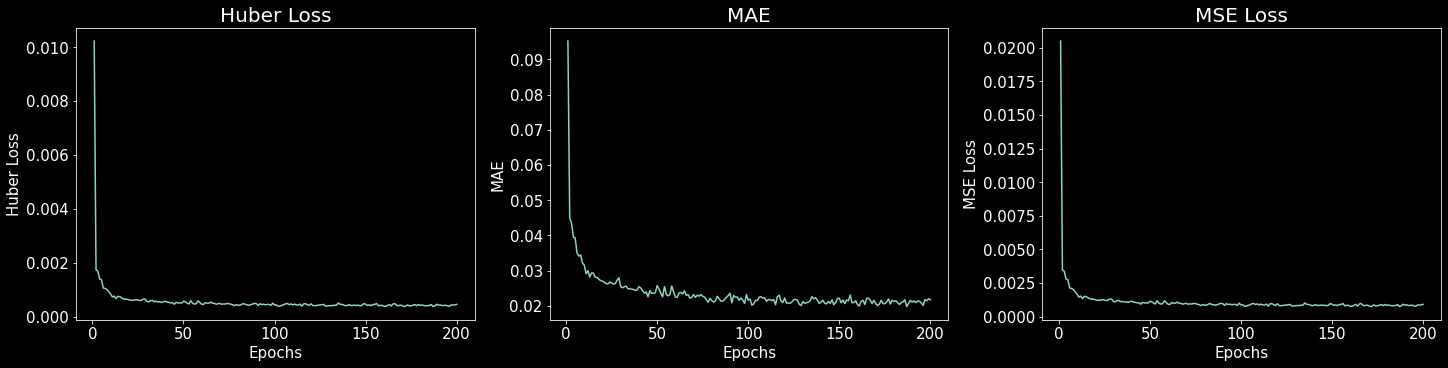

In [17]:
X_train, Y_train = get_windowed_dataset(data, window_size, split_point)
model = get_model(window_size)
model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'mean_squared_error', metrics = ['mae', tf.keras.losses.Huber()])
model_hist = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size)
plot_metrics(model_hist.history, epochs = epochs)

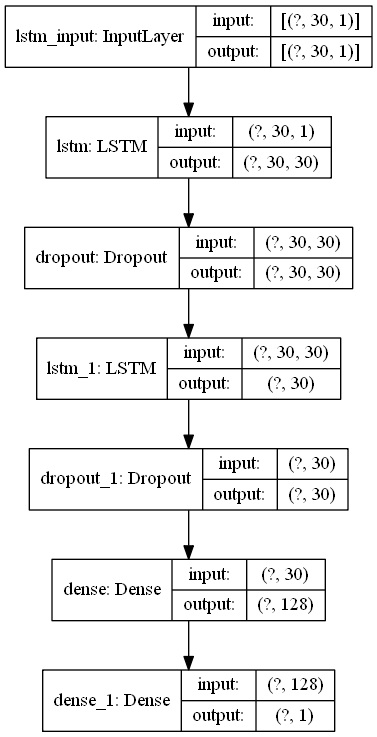

In [18]:
tf.keras.utils.plot_model(model, to_file = 'LSTM_arch.png', show_shapes = True, show_layer_names = True)

In [17]:
def model_forecast(data, model, window_size, split_point, sc):
  data = data.iloc[:, 4:5]
  data = data[split_point - window_size:].values

  data = data.reshape(-1, 1)
  data = sc.transform(data)

  X_test = []
  for i in range(window_size, len(data)):
    X_test.append(data[i-window_size : i, 0])

  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  print(model.predict(X_test).shape)
  preds = sc.inverse_transform(model.predict(X_test))
  return preds
    

(820, 1)


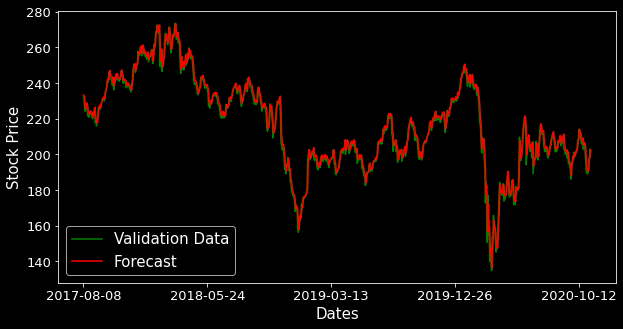

In [20]:
plt.style.use('dark_background')
plt.figure(figsize = (10, 5))

date_ticks = []
x_ticks_pos = []
for i, j in enumerate(val_dates):
  if not i%200:
    date_ticks.append(j)
    x_ticks_pos.append(i)

forecast = model_forecast(data, model, window_size, split_point, sc)
val_data = data.iloc[split_point:, 4:5].values

plt.plot(val_data, 'g')
plt.plot(forecast, 'r')
plt.xticks(x_ticks_pos, date_ticks)
plt.tick_params(axis = 'both', labelsize = 13)
plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Stock Price', fontsize = 15)
plt.legend(['Validation Data', 'Forecast'], fontsize = 15)
plt.show()

In [21]:
print('LSTM error: ', mse(val_data, forecast))

LSTM error:  18.70348455989873


# LSTM Autoencoder

In [18]:
forecast_steps = 1

In [19]:
def get_windowed_dataset_autoencoder(data, window_size, forecast_steps, split_point):
  train_data = sc.fit_transform(data.iloc[:split_point-forecast_steps, 4:5].values)
  val_data = sc.fit_transform(data.iloc[split_point-forecast_steps:, 4:5].values)
  whole_data = sc.fit_transform(data.iloc[:, 4:5].values)
  X_train = []
  Y_train = []

  for i in range(window_size, split_point-forecast_steps):
    X_train.append(np.array(train_data[i-window_size : i, 0]))
    Y_train.append(np.array(whole_data[i : i+forecast_steps, 0]))
    
  X_train = np.array(X_train)
  Y_train = np.array(Y_train)
  print(X_train.shape)
  print(Y_train.shape)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))

  return X_train, Y_train

In [20]:
def autoencoder_model(window_size = window_size, forecast_steps = forecast_steps):

    model = models.Sequential()
    model.add(layers.LSTM(units = window_size, input_shape = (X_train.shape[1], 1)))
    # model.add(layers.Dropout(0.2))
    # model.add(layers.LSTM(units = 100))
    # model.add(layers.Dropout(0.2))
    model.add(layers.RepeatVector(forecast_steps))
    model.add(layers.LSTM(units = window_size, return_sequences = True))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(100))
    model.add(layers.TimeDistributed(layers.Dense(1)))
    # model.add(layers.Dense(1))
    model.summary()
    return model

In [21]:
def autoencoder_model_forecast(data, model, window_size, split_point, sc):
  data = data.iloc[:, 4:5]
  data = data[split_point - window_size:].values

  data = data.reshape(-1, 1)
  data = sc.transform(data)

  X_test = []
  for i in range(window_size, len(data)):
    X_test.append(data[i-window_size : i, 0])

  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  preds = model.predict(X_test)
  preds = np.reshape(preds, (preds.shape[0], preds.shape[1]))
  preds = sc.inverse_transform(preds)
  return preds

=====================] - 1s 352us/sample - loss: 6.9693e-04 - mae: 0.0195 - huber_loss: 3.4790e-04
Epoch 51/200
1882/1882 [==============================] - 1s 363us/sample - loss: 6.5242e-04 - mae: 0.0186 - huber_loss: 3.2595e-04
Epoch 52/200
1882/1882 [==============================] - 1s 378us/sample - loss: 6.8860e-04 - mae: 0.0194 - huber_loss: 3.4444e-04
Epoch 53/200
1882/1882 [==============================] - 1s 357us/sample - loss: 7.2333e-04 - mae: 0.0198 - huber_loss: 3.6156e-04
Epoch 54/200
1882/1882 [==============================] - 1s 372us/sample - loss: 7.4611e-04 - mae: 0.0200 - huber_loss: 3.7409e-04
Epoch 55/200
1882/1882 [==============================] - 1s 351us/sample - loss: 6.8682e-04 - mae: 0.0189 - huber_loss: 3.4324e-04
Epoch 56/200
1882/1882 [==============================] - 1s 345us/sample - loss: 7.1637e-04 - mae: 0.0194 - huber_loss: 3.5860e-04
Epoch 57/200
1882/1882 [==============================] - 1s 337us/sample - loss: 6.5185e-04 - mae: 0.0186 - 

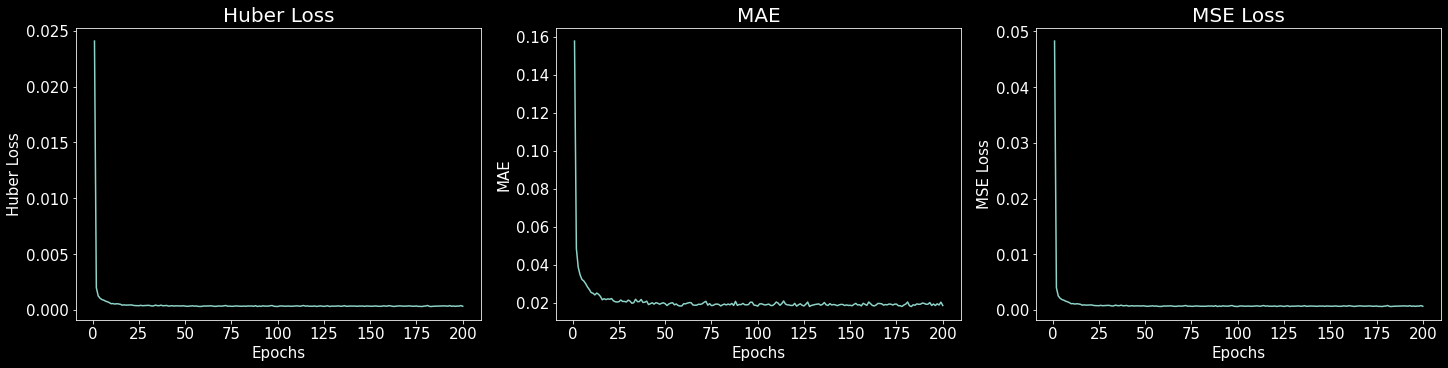

In [22]:
X_train, Y_train = get_windowed_dataset(data, window_size, split_point)
autoencoder = autoencoder_model(window_size)
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'mean_squared_error', metrics = ['mae', tf.keras.losses.Huber()])
auto_hist = autoencoder.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size)
plot_metrics(auto_hist.history, epochs = epochs)

In [23]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3840      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 30)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 30)             7320      
_________________________________________________________________
dropout (Dropout)            (None, 1, 30)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 100)            3100      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)              101       
Total params: 14,361
Trainable params: 14,361
Non-trainable params: 0
____________________________________________________

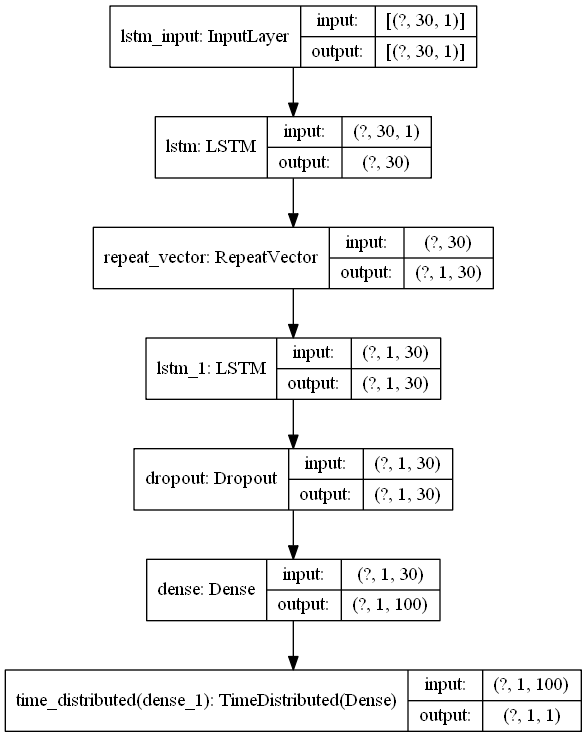

In [24]:
tf.keras.utils.plot_model(autoencoder, to_file = 'autoenc_arch.png', show_layer_names=True, show_shapes = True)

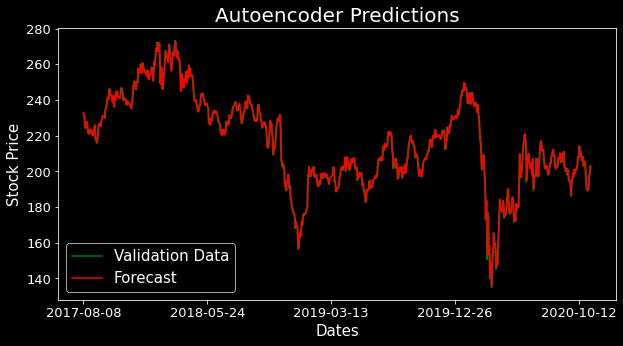

In [25]:
plt.style.use('dark_background')
plt.figure(figsize = (10, 5))

date_ticks = []
x_ticks_pos = []
for i, j in enumerate(val_dates):
  if not i%200:
    date_ticks.append(j)
    x_ticks_pos.append(i)

forecast = autoencoder_model_forecast(data, autoencoder, window_size, split_point, sc)
val_data = data.iloc[split_point:, 4:5].values

plt.plot(val_data[:, 0], 'g')
plt.plot(forecast, 'r')
plt.xticks(x_ticks_pos, date_ticks)
plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Stock Price', fontsize = 15)
plt.xticks(x_ticks_pos, date_ticks)
plt.tick_params(axis='both', labelsize = 13)
plt.legend(['Validation Data', 'Forecast'], fontsize = 15)
plt.title('Autoencoder Predictions', fontsize = 20)
plt.show()

In [26]:
mse(val_data[:, 0], forecast)

17.349904026612766

In [35]:
forecast.shape

(820, 1)